# Battle of Neighborhood

Choose the neighborhood to open a cafe

Get neighborhood data of Toronto

In [4]:
import pandas as pd
import numpy as np
import requests

In [5]:
# get neighborhood data from wiki
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
rdata=requests.get(url)

In [6]:
print(rdata.status_code)

200


Use BeautifulSoup to extract data, data locates in 'table'

In [7]:
from bs4 import BeautifulSoup
soupdata=BeautifulSoup(rdata.content,'html.parser')
#print(soupdata.prettify())

In [8]:
rtable=soupdata.find('table',class_='wikitable sortable')
#rtable

In [9]:
#test=rtable.find_all('tr')
#type(rtable)

In [10]:
# get the neighborhood list from table
m=[]

for tr in rtable.find_all('tr'):
    td=tr.find_all('td')
    row=[tr.text for tr in td]
    m.append(row)
pctable=pd.DataFrame(m,columns=['PostalCode','Borough','Neighbourhood'])
pctable.head()

,PostalCode,Borough,Neighbourhood
0,None,None,None
1,M1A\n,Not assigned\n,Not assigned\n
2,M2A\n,Not assigned\n,Not assigned\n
3,M3A\n,North York\n,Parkwoods\n
4,M4A\n,North York\n,Victoria Village\n


In [11]:
# remove \n from table and None and Not assigned
for col in pctable.columns:
    pctable[col]=pctable[col].astype(str).str.replace('\n','')
pctable.replace('Not assigned',np.nan,inplace=True)
pctable.replace('None',np.nan,inplace=True)
pctable.head()

,PostalCode,Borough,Neighbourhood
0,NaN,NaN,NaN
1,M1A,NaN,NaN
2,M2A,NaN,NaN
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village


In [12]:
ftable=pctable.dropna()
ftable.reset_index(drop=True,inplace=True)
ftable.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [13]:
# get the shape of the final table
ftable.shape

(103, 3)

Get location/coordinates of neighborhood

In [14]:
from geopy.geocoders import Nominatim 

In [15]:
#!wget -O Geospatial_Coordinates.csv https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
#Location=pd.read_csv('Geospatial_Coordinates.csv')
Location=pd.read_csv('C:\Geospatial_Coordinates.csv')

In [17]:
Location.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
Location.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
Mergedf=pd.merge(ftable,Location,on='PostalCode',how='left')
Mergedf.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Get the venues from Foursqures and analyze the neighborhood

In [18]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from pandas.io.json import json_normalize
import folium

In [21]:
# create map using latitude and longitude values
Latitude = Mergedf.loc[0, 'Latitude'] 
Longitude = Mergedf.loc[0, 'Longitude'] 
map_toronto = folium.Map(location=[Latitude, Longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Mergedf['Latitude'], Mergedf['Longitude'], Mergedf['PostalCode']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [22]:
#@hidden_cell
#Define Foursquare Credentials and Version
CLIENT_ID = 'UATWYBYLMR5W2JEV43ZD2CEUH3L44DA341DCJXZZGRJCHCEG' 
CLIENT_SECRET = 'KIFU1ELIAMAA1VNZKKHCUMSWYREGGCEBTQ40R3KIMU2SEVWJ' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Explore Neighborehood using postalcode for the following analysis

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalZone Latitude', 
                  'PostalZone Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
toronto_venues = getNearbyVenues(names=Mergedf['PostalCode'],
                                   latitudes=Mergedf['Latitude'],
                                   longitudes=Mergedf['Longitude']
                                  )

In [26]:
toronto_venues.head()

,PostalCode,PostalZone Latitude,PostalZone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [27]:
toronto_venues.shape

(2166, 7)

In [28]:
#check how many unique categories from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
np.sort(toronto_venues['Venue Category'].unique())

There are 277 uniques categories.


array(['Accessories Store', 'Afghan Restaurant', 'Airport',
       'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal', 'American Restaurant',
       'Antique Shop', 'Aquarium', 'Art Gallery', 'Art Museum',
       'Arts & Crafts Store', 'Asian Restaurant', 'Athletics & Sports',
       'Auto Garage', 'Auto Workshop', 'BBQ Joint', 'Baby Store',
       'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Baseball Field',
       'Baseball Stadium', 'Basketball Stadium', 'Beach',
       'Bed & Breakfast', 'Beer Bar', 'Beer Store', 'Belgian Restaurant',
       'Bike Shop', 'Bistro', 'Boat or Ferry', 'Bookstore', 'Boutique',
       'Bowling Alley', 'Brazilian Restaurant', 'Breakfast Spot',
       'Brewery', 'Bridal Shop', 'Bubble Tea Shop', 'Building',
       'Burger Joint', 'Burrito Place', 'Bus Line', 'Bus Station',
       'Business Service', 'Butcher', 'Café', 'Cajun / Creole Restaurant',
       'Camera Store', 'Candy Store', 'Caribbean Restaurant',
    

Analyze neighborhood using postalcode for this analysis

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add PostalCode column back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
toronto_onehot.shape

(2166, 278)

group rows by PostalCode and by taking the mean of the frequency of occurrence of each category

In [31]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
toronto_grouped.shape

(100, 278)

Get each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for pcode in toronto_grouped['PostalCode']:
    print("----"+pcode+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == pcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                       venue  freq
0       Fast Food Restaurant   1.0
1          Accessories Store   0.0
2  Middle Eastern Restaurant   0.0
3        Moroccan Restaurant   0.0
4        Monument / Landmark   0.0


----M1C----
                        venue  freq
0  Construction & Landscaping   0.5
1                         Bar   0.5
2           Accessories Store   0.0
3           Mobile Phone Shop   0.0
4                       Motel   0.0


----M1E----
                 venue  freq
0       Medical Center  0.12
1  Rental Car Location  0.12
2       Breakfast Spot  0.12
3                 Bank  0.12
4   Mexican Restaurant  0.12


----M1G----
                   venue  freq
0            Coffee Shop  0.50
1     Mexican Restaurant  0.25
2  Korean BBQ Restaurant  0.25
3      Accessories Store  0.00
4      Mobile Phone Shop  0.00


----M1H----
                  venue  freq
0                Bakery  0.12
1  Caribbean Restaurant  0.12
2       Thai Restaurant  0.12
3           Gas Station  0

sort the venues in descending order

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M1C,Construction & Landscaping,Bar,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M1E,Intersection,Breakfast Spot,Electronics Store,Restaurant,Medical Center,Rental Car Location,Bank,Mexican Restaurant,Doner Restaurant,Distribution Center
3,M1G,Coffee Shop,Mexican Restaurant,Korean BBQ Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Yoga Studio
4,M1H,Gas Station,Fried Chicken Joint,Bakery,Bank,Athletics & Sports,Thai Restaurant,Caribbean Restaurant,Hakka Restaurant,Eastern European Restaurant,Dumpling Restaurant


In [36]:
# check the number of venues
toronto_grouped_num = toronto_onehot.groupby('PostalCode').sum().reset_index()
toronto_grouped_num.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1H,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
toronto_grouped_num[['PostalCode','Coffee Shop']].sort_values('Coffee Shop',ascending=False)

,PostalCode,Coffee Shop
58,M5K,14
57,M5J,13
55,M5G,12
59,M5L,12
68,M5X,10
...,...,...
43,M4P,0
46,M4T,0
48,M4W,0
1,M1C,0


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

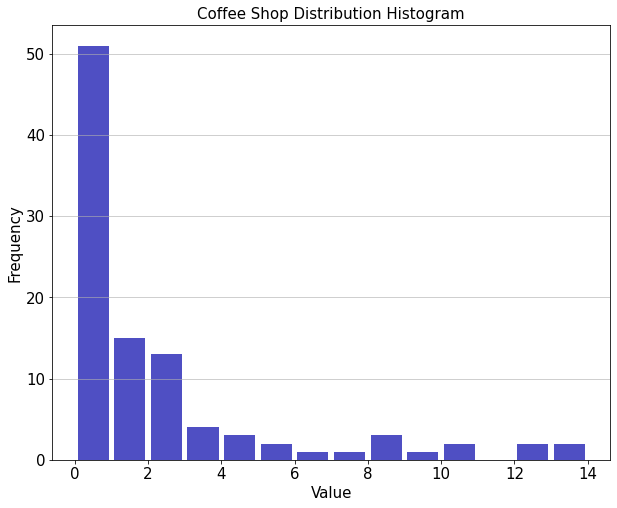

In [44]:
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist(x=toronto_grouped_num['Coffee Shop'], bins=14, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Coffee Shop Distribution Histogram',fontsize=15)
plt.show()

split the data frame into two: one with coffee shop, one without coffee shop

In [45]:
coffee_data=toronto_grouped_num[toronto_grouped_num['Coffee Shop']>0]
coffee_data.shape

(49, 278)

In [46]:
noncoffee_data=toronto_grouped_num[toronto_grouped_num['Coffee Shop']==0]
noncoffee_data.shape

(51, 278)

In [47]:
coffee_data_norm=toronto_grouped[toronto_grouped['Coffee Shop']>0]
coffee_data_norm.shape

(49, 278)

In [48]:
noncoffee_data_norm=toronto_grouped[toronto_grouped['Coffee Shop']==0]
noncoffee_data_norm.shape

(51, 278)

get the correlation matrix from the data frame with coffee shop, in order to predict the coffee shop number for a neighborhood

In [58]:
corrMatrix=coffee_data.corr()
corrMatrix.shape

(277, 277)

In [50]:
import seaborn as sn

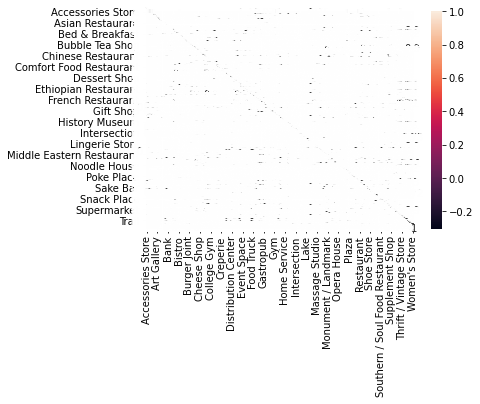

In [51]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [52]:
corrMatrix_nna=corrMatrix.dropna(subset=['Coffee Shop'])

In [64]:
# remove na from correlation matrix
corrMatrix_nna.head(10)

,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Accessories Store,1.000000,-0.020833,-0.020833,-0.020833,-0.020833,-0.020833,-0.020833,-0.020833,-0.078008,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,0.201299,-0.020833,-0.073088,NaN,0.280124,-0.078870
Afghan Restaurant,-0.020833,1.000000,-0.020833,-0.020833,-0.020833,-0.020833,-0.020833,-0.020833,0.081258,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,0.201299,-0.020833,-0.073088,NaN,-0.031832,0.515692
Airport,-0.020833,-0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.078008,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,-0.051615,-0.020833,-0.073088,NaN,-0.031832,-0.078870
Airport Food Court,-0.020833,-0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.078008,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,-0.051615,-0.020833,-0.073088,NaN,-0.031832,-0.078870
Airport Gate,-0.020833,-0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.078008,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,-0.051615,-0.020833,-0.073088,NaN,-0.031832,-0.078870
Airport Lounge,-0.020833,-0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.078008,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,-0.051615,-0.020833,-0.073088,NaN,-0.031832,-0.078870
Airport Service,-0.020833,-0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.078008,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,-0.051615,-0.020833,-0.073088,NaN,-0.031832,-0.078870
Airport Terminal,-0.020833,-0.020833,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.078008,-0.029775,...,-0.043033,NaN,-0.066281,-0.036860,-0.051615,-0.020833,-0.073088,NaN,-0.031832,-0.078870
American Restaurant,-0.078008,0.081258,-0.078008,-0.078008,-0.078008,-0.078008,-0.078008,-0.078008,1.000000,0.002323,...,0.332335,NaN,0.321860,-0.044089,-0.114349,-0.078008,0.508568,NaN,0.124158,-0.017038
Antique Shop,-0.029775,-0.029775,-0.029775,-0.029775,-0.029775,-0.029775,-0.029775,-0.029775,0.002323,1.000000,...,-0.061502,NaN,0.050324,-0.052680,-0.073767,-0.029775,-0.104456,NaN,-0.045494,0.312148


In [54]:
corrMatrix_nna.shape

(245, 277)

In [67]:
corrMatrix['Coffee Shop'].unique()

array([-0.1148029 ,  0.12122544, -0.1148029 ,  0.53983528,  0.28569515,
        0.35725379,  0.70969067,  0.34191628, -0.05163165,  0.4869538 ,
       -0.13596335,         nan, -0.01751861, -0.1148029 ,  0.05921391,
        0.52472524,  0.07928565,  0.29890697,  0.04254933,  0.35725379,
        0.5347994 ,  0.04254933,  0.00321127,  0.6130011 , -0.09701417,
        0.06081061, -0.07974222,  0.37228671,  0.29273777, -0.11031989,
        0.31434195,  0.21660711, -0.07546485,  0.41174511,  0.1605635 ,
        0.36153538,  0.20447573,  0.69193211,  0.08188739,  0.00749991,
        0.19171847,  0.24127312,  0.14514231,  0.23923962, -0.07546485,
        0.19681334,  0.32683097,  1.        , -0.1148029 ,  0.1605635 ,
        0.19990156,  0.05676777,  0.37002685,  0.59397789, -0.09493726,
        0.26340245, -0.03612679,  0.42082955, -0.10785279,  0.2144846 ,
        0.34191628,  0.64232209,  0.59461166,  0.12908238,  0.28986033,
        0.12708482,  0.33165854,  0.00321127, -0.01751861,  0.14

In [127]:
cs_corrvalue=corrMatrix_nna[['Coffee Shop']]
#cs_corrvalue=np.sort(cs_corrvalue)[::-1]
cs_corrvalue.sort_values('Coffee Shop',ascending=False,inplace=True)
cs_corrvalue.head()

<ipython-input-127-92b8a9b59a85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_corrvalue.sort_values('Coffee Shop',ascending=False,inplace=True)


,Coffee Shop
Coffee Shop,1.000000
Hotel,0.821543
Tea Room,0.756147
Restaurant,0.745617
New American Restaurant,0.743129


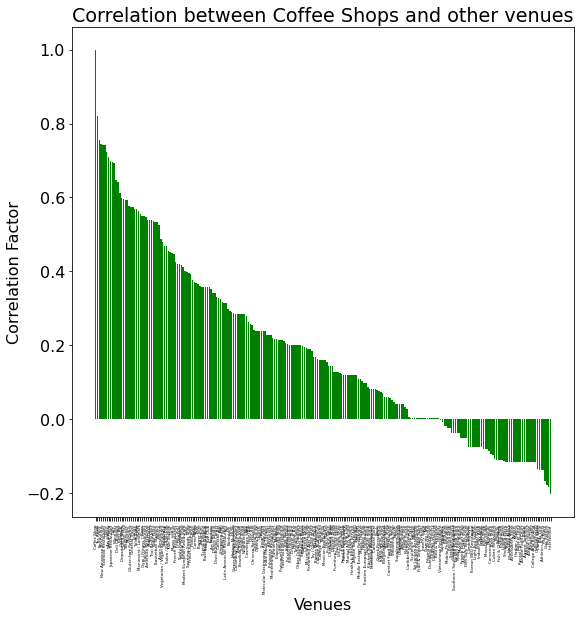

In [131]:
plt.bar(cs_corrvalue.index, cs_corrvalue['Coffee Shop'], color='green')
plt.xlabel("Venues")
plt.ylabel("Correlation Factor")
plt.title("Correlation between Coffee Shops and other venues")

plt.xticks(cs_corrvalue.index, rotation=90, fontsize=4)

plt.show()

In [68]:
# all shops have correlation with coffee shop
corr_item=corrMatrix_nna.index

In [69]:
corr_item

Index(['Accessories Store', 'Afghan Restaurant', 'Airport',
       'Airport Food Court', 'Airport Gate', 'Airport Lounge',
       'Airport Service', 'Airport Terminal', 'American Restaurant',
       'Antique Shop',
       ...
       'Toy / Game Store', 'Trail', 'Train Station',
       'Vegetarian / Vegan Restaurant', 'Video Game Store',
       'Vietnamese Restaurant', 'Warehouse Store', 'Wine Bar', 'Women's Store',
       'Yoga Studio'],
      dtype='object', length=245)

In [74]:
#data frame with all correlated shops
coffee_data_corr=coffee_data[coffee_data.columns & corr_item]
coffee_data_corr = coffee_data_corr.reindex(columns=(['Coffee Shop'] + list([a for a in coffee_data_corr.columns if a != 'Coffee Shop']) ))
coffee_data_corr=coffee_data_corr.reset_index(drop=True)
coffee_data_corr.head()

,Coffee Shop,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,3,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [75]:
# data frame of no coffee shop with all correlated shops
noncoffee_data_corr=noncoffee_data[noncoffee_data.columns & corr_item]
noncoffee_data_corr = noncoffee_data_corr.reindex(columns=(['Coffee Shop'] + list([a for a in noncoffee_data_corr.columns if a != 'Coffee Shop']) ))
noncoffee_data_corr=noncoffee_data_corr.reset_index(drop=True)
noncoffee_data_corr.head()

,Coffee Shop,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
#try linear regression
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
X=coffee_data_corr.iloc[:,1:244]
y=coffee_data_corr['Coffee Shop']
lm.fit(X,y)
lm.coef_

array([ 0.05135122,  0.00644817, -0.01423072, -0.01423072, -0.01423072,
       -0.02846145, -0.02846145, -0.01423072,  0.01147544,  0.0881202 ,
        0.12184392,  0.47368794,  0.27020947, -0.05275399, -0.04065484,
        0.01274276, -0.01241172, -0.07609037,  0.014597  ,  0.18589223,
        0.33769204, -0.10659569,  0.07365141,  0.04873757,  0.13249715,
        0.00985904, -0.02333094,  0.27762594, -0.15420515, -0.03627883,
       -0.02219304,  0.02592885, -0.01423072, -0.3725529 ,  0.11077191,
       -0.05168448,  0.26002551, -0.08922449, -0.10013526,  0.45254398,
       -0.00635797,  0.3545372 ,  0.01473233,  0.00636227,  0.07365141,
        0.13645512,  0.02561673, -0.0129479 , -0.13203044, -0.06653309,
       -0.01303034,  0.16974481,  0.15712269,  0.00464892,  0.09064249,
       -0.117339  , -0.20197543, -0.18961785,  0.44311195,  0.44311195,
       -0.18961785, -0.05230807, -0.05168448, -0.43097221,  0.22425936,
        0.06099826,  0.15955824,  0.06208329, -0.00576744,  0.41

In [78]:
X_non=noncoffee_data_corr.iloc[:,1:244]
y_predict=lm.predict(X_non)

In [79]:
#numpy array sort by descending
np.sort(y_predict)[::-1]

array([3.72763713, 2.53338864, 2.34246595, 2.18134209, 2.01051514,
       1.85942408, 1.85308976, 1.8524187 , 1.71312003, 1.71043345,
       1.69675807, 1.66016208, 1.62195212, 1.61042083, 1.58647122,
       1.56015652, 1.5479037 , 1.53382253, 1.49877889, 1.45222573,
       1.40344082, 1.40196949, 1.39881112, 1.38071246, 1.38062656,
       1.34179783, 1.32347214, 1.3144853 , 1.29917689, 1.27844182,
       1.2776447 , 1.27234421, 1.2357567 , 1.23570877, 1.23570877,
       1.18045712, 1.1735328 , 1.16850553, 1.16205736, 1.16205736,
       1.15501228, 1.15348337, 1.10582282, 1.1007532 , 1.05546167,
       1.04123095, 1.01417016, 0.96232304, 0.88035104, 0.87696369,
       0.26596028])

the highest predicted coffee shop numbers is around 4 in one of the neighborhoods, this is using all the other shops and full data set for training; next we will try the other ML models and split training and testing data sets

In [81]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [82]:
#y_hat=lm.predict(X)

In [83]:
#errors = y_hat - y
#mae = np.mean(abs(errors))

In [84]:
#rmse = np.sqrt(np.mean(errors ** 2))
#rmse

In [85]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [86]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    #X_train = X_train.drop(columns='Grade')
    #X_test = X_test.drop(columns='Grade')

    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    
    
    return results

In [87]:
results = evaluate(X_train, X_test, y_train, y_test)

In [88]:
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

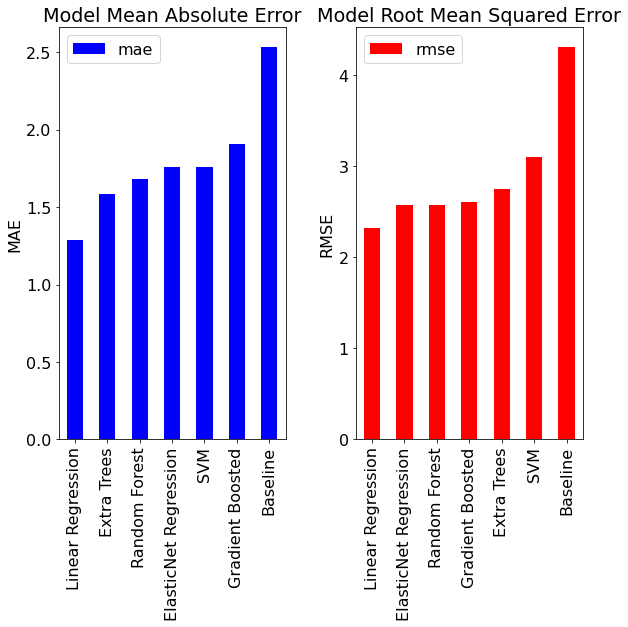

In [89]:
#Visual Comparison of Models
figsize=(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [90]:
results

,mae,rmse
Linear Regression,1.28699,2.3239
ElasticNet Regression,1.75553,2.56829
Random Forest,1.68267,2.56917
Extra Trees,1.58133,2.74418
SVM,1.75892,3.09648
Gradient Boosted,1.90635,2.60797
Baseline,2.53333,4.30504


In [92]:
# Evaluate several ml models by training on training set and testing on testing set
# get the predicted coffee shop numbers for each neighborhood which doesn't have coffee shop yet
def eva_nbhd(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    #X_train = X_train.drop(columns='Grade')
    #X_test = X_test.drop(columns='Grade')
    cs_p=pd.DataFrame(noncoffee_data['PostalCode']) #predicted coffee shops from non
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        cs_prediction=model.predict(X_non)
        cs_p[model_name_list[i]]=cs_prediction
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    
    
    return cs_p

In [93]:
cs_p = eva_nbhd(X_train, X_test, y_train, y_test)
cs_p

,PostalCode,Linear Regression,ElasticNet Regression,Random Forest,Extra Trees,SVM,Gradient Boosted
0,M1B,0.871696,2.021042,1.08,1.00,1.518536,1.682547
1,M1C,1.226102,2.021042,1.12,1.00,1.525633,1.682547
2,M1E,2.576944,2.274831,1.70,1.82,1.788216,1.859084
4,M1H,1.826986,2.059587,1.38,2.42,1.730073,1.800153
5,M1J,1.130287,2.021042,1.12,1.00,1.546295,1.682547
7,M1L,1.467045,2.315086,1.16,1.00,1.813344,1.682547
8,M1M,1.239878,2.021042,1.26,1.36,1.569358,1.809949
9,M1N,1.157932,2.203368,1.14,1.00,1.630572,1.682547
10,M1P,1.190409,2.021042,1.22,1.88,1.591496,1.682547
11,M1R,1.171037,2.059587,1.06,1.04,1.624640,1.682547


In [97]:
cs_p.sort_values('Linear Regression',ascending=False,inplace=True)

In [104]:
cs_p_combine=pd.merge(cs_p,Mergedf,on='PostalCode',how='left')
cs_p_combine=cs_p_combine.iloc[0:6,:]

In [105]:
cs_p_combine

,PostalCode,Linear Regression,ElasticNet Regression,Random Forest,Extra Trees,SVM,Gradient Boosted,Borough,Neighbourhood,Latitude,Longitude
0,M6P,3.897320,2.641193,2.10,2.36,2.390410,3.555138,West Toronto,"High Park, The Junction South",43.661608,-79.464763
1,M1E,2.576944,2.274831,1.70,1.82,1.788216,1.859084,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
2,M6H,2.160494,2.497412,1.86,2.02,1.964447,2.959219,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
3,M4P,2.138635,3.188268,4.38,1.66,1.852964,5.928621,Central Toronto,Davisville North,43.712751,-79.390197
4,M5P,2.118647,2.237996,1.62,1.84,1.698490,1.859084,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307
5,M3L,2.025981,3.188268,4.20,1.58,1.759907,6.124065,North York,Downsview,43.739015,-79.506944


In [109]:
# visualize the best neighborhood to open a coffee shop
Latitude = cs_p_combine.loc[0, 'Latitude'] 
Longitude = cs_p_combine.loc[0, 'Longitude'] 
map_coffeeshop = folium.Map(location=[Latitude, Longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cs_p_combine['Latitude'], cs_p_combine['Longitude'], cs_p_combine['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_coffeeshop)  
    
map_coffeeshop